# EI Balance

This notebook...

## Imports

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# custom imports
import sys
sys.path.append('../../')
from allen_vc.plots import plot_regression_line
from allen_vc.stats import mixedLM
from allen_vc.paths import PATH_EXTERNAL
from scipy.stats import linregress

print("Packages Imported!")

Packages Imported!


## Settings

In [3]:
# matplotlib and figure appearance settings
plt.style.use(f'../../stylelib/sfn_2023.mplstyle')

## Helper functions

In [4]:
# calc EI balance from DataFrame
def calc_EI(df):
    
    E = df.loc[df['cell_type'] == 'excitatory', 'mean_firing_rate'].values[0]
    I = df.loc[df['cell_type'] == 'inhibitory', 'mean_firing_rate'].values[0]
    
    Ec = df.loc[df['cell_type'] == 'excitatory', 'unit_count'].values[0]
    Ic = df.loc[df['cell_type'] == 'inhibitory', 'unit_count'].values[0]
    
    return pd.DataFrame({'EI_balance': [E/I], 'excitatory_count': [Ec], 'inhibitory_count':[Ic]})

## Load data

In [5]:
# load combined lfp_spike data

# load data for beahvior: stationary
stationary_spikes = pd.read_csv(f'{PATH_EXTERNAL}/data/spike_stats/region_metrics/spontaneous_stationary.csv').assign(behavior='stationary')
stationary_lfp = pd.read_csv(f'{PATH_EXTERNAL}/data/lfp_data/params/psd/spontaneous_stationary/lfp_params.csv')

# modify df_lfp - average over channels for each epoch within each session
stationary_lfp_i = stationary_lfp.groupby(['session', 'epoch_idx']).mean().reset_index().drop(columns=['chan_idx']).assign(behavior='stationary')

# merge lfp and spike data
nan_i = stationary_lfp_i.merge(stationary_spikes, on=['session', 'epoch_idx', 'behavior'])

# drop nan
behavior_df = nan_i.dropna(subset=['offset'])
print(f'Number of rows after dropping NaNs: {len(nan_i)-len(behavior_df)}')

Number of rows after dropping NaNs: 8


In [67]:
# load data for stim: natural_movie_one_more_repeats

movie_spikes = pd.read_csv(f'{PATH_EXTERNAL}/data/spike_stats/region_metrics/natural_movie_one_more_repeats.csv').assign(presentation='movie')
movie_lfp = pd.read_csv(f'{PATH_EXTERNAL}/data/lfp_data/params/psd/natural_movie_one_more_repeats/lfp_params.csv')

# load data for stim: natural_movie_one_shuffled

shuffled_spikes = pd.read_csv(f'{PATH_EXTERNAL}/data/spike_stats/region_metrics/natural_movie_one_shuffled.csv').assign(presentation='shuffled')
shuffled_lfp = pd.read_csv(f'{PATH_EXTERNAL}/data/lfp_data/params/psd/natural_movie_one_shuffled/lfp_params.csv')

# modify df_lfp - average over channels for each epoch within each session
movie_lfp_i = movie_lfp.groupby(['session', 'epoch_idx']).mean().reset_index().drop(columns=['chan_idx']).assign(presentation='movie')
shuffled_lfp_i = shuffled_lfp.groupby(['session', 'epoch_idx']).mean().reset_index().drop(columns=['chan_idx']).assign(presentation='shuffled')

# concatenate movie and shuffled epoch data
lfp_i = pd.concat([movie_lfp_i, shuffled_lfp_i])
units_i = pd.concat([movie_spikes, shuffled_spikes])

# merge lfp and spike data
nans_i = lfp_i.merge(units_i, on=['session', 'epoch_idx', 'presentation'])

# only consider stationary epochs
nans_i = nans_i[~nans_i['running']]

# drop nan
presentation_df = nans_i.dropna(subset=['offset'])
print(f'Number of rows after dropping NaNs: {len(nans_i)-len(presentation_df)}')

Number of rows after dropping NaNs: 1


In [4]:
# load cell_type specific spike data

# spont
spont = pd.read_csv(f'{PATH_EXTERNAL}/data/spike_stats/by_cell_type/pop_metrics/spontaneous_stationary.csv')

# movie (filter for stationary)
movie = pd.read_csv(f'{PATH_EXTERNAL}/data/spike_stats/by_cell_type/pop_metrics/natural_movie_one_more_repeats.csv')
movie = movie.loc[~movie['running']]

# shuffled (filter for stationary)
shuffled = pd.read_csv(f'{PATH_EXTERNAL}/data/spike_stats/by_cell_type/pop_metrics/natural_movie_one_shuffled.csv')
shuffled = shuffled.loc[~shuffled['running']]

Take a look at cell_type unit counts

In [130]:
spont.groupby(['cell_type'])['unit_count'].sum()

cell_type
excitatory    34066
inhibitory     7294
undefined      4088
Name: unit_count, dtype: int64

In [6]:
movie.groupby(['cell_type'])['unit_count'].sum()

cell_type
excitatory    32234
inhibitory     7078
undefined      3987
Name: unit_count, dtype: int64

In [7]:
shuffled.groupby(['cell_type'])['unit_count'].sum()

cell_type
excitatory    10862
inhibitory     2271
undefined      1506
Name: unit_count, dtype: int64

## Main

In [8]:
# filter for only E or I units
spont_EI = spont.loc[spont['cell_type'] != 'undefined']
movie_EI = movie.loc[movie['cell_type'] != 'undefined']
shuffled_EI = shuffled.loc[shuffled['cell_type'] != 'undefined']

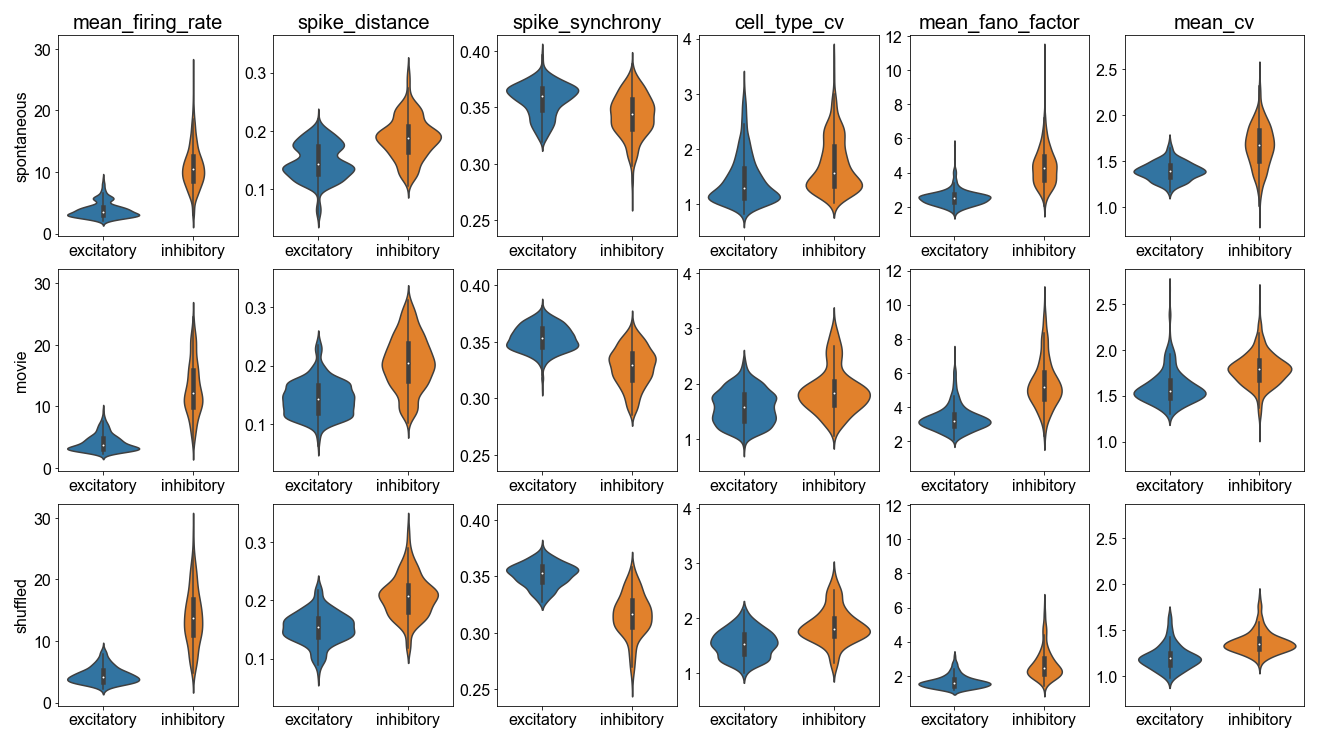

In [9]:
# compare spike metrics between excitatory and inhibitory populations

dfs = {'spontaneous': spont_EI, 'movie': movie_EI, 'shuffled': shuffled_EI}
metrics = ['mean_firing_rate', 'spike_distance', 'spike_synchrony','cell_type_cv', 'mean_fano_factor', 'mean_cv']
fig, ax = plt.subplots(3, len(metrics), figsize=(18, 10), sharey='col')


for i, df_name in enumerate(dfs.keys()):
    for j, metric in enumerate(metrics):

        sns.violinplot(data=dfs[df_name], x='cell_type', y=metric, ax=ax[i, j])
        ax[i, j].set_xlabel('')
        
        if i == 0:
            ax[i,j].set_title(metric)
            
        if j == 0:
            ax[i, j].set_ylabel(df_name)
        else:
            ax[i, j].set_ylabel('')
        

In [173]:
# calculate E/I balance per epoch
spont_df_EI = spont_EI.groupby(['session', 'epoch_idx'])[['cell_type', 'mean_firing_rate', 'unit_count']].apply(calc_EI).reset_index().drop(columns='level_2')
spont_df_EI.head()

,session,epoch_idx,EI_balance,excitatory_count,inhibitory_count
0,766640955,0,0.585096,35,10
1,766640955,1,0.624046,35,10
2,766640955,2,0.627663,35,10
3,766640955,3,0.617593,35,10
4,766640955,4,0.654859,35,10


In [171]:
# calculate E/I balance per epoch (pres)
pres_EI = pd.concat([movie_EI, shuffled_EI])
pres_df_EI = pres_EI.groupby(['session', 'epoch_idx'])[['cell_type', 'mean_firing_rate', 'unit_count']].apply(calc_EI).reset_index().drop(columns='level_2')
pres_df_EI.head()

,session,epoch_idx,EI_balance,excitatory_count,inhibitory_count
0,766640955,0,0.635170,35,10
1,766640955,1,0.556084,35,10
2,766640955,2,0.506300,35,10
3,766640955,3,0.540428,35,10
4,766640955,4,0.638275,35,10


In [174]:
# combine this data with lfp and spike metrics per epoch

# NOTE: some epochs are cut out in behavior_df compared to df_EI (likely due to invalid LFP)

behavior_df_EI = behavior_df[behavior_df['brain_structure']=='VISp'].merge(spont_df_EI, on=['session', 'epoch_idx'])
presentation_df_EI = presentation_df[presentation_df['brain_structure']=='VISp'].merge(pres_df_EI, on=['session', 'epoch_idx'])

In [149]:
behavior_df_EI.columns

Index(['session', 'epoch_idx', 'offset', 'knee', 'exponent', 'cf_0', 'pw_0',
       'bw_0', 'cf_1', 'pw_1', 'bw_1', 'cf_2', 'pw_2', 'bw_2', 'cf_3', 'pw_3',
       'bw_3', 'error', 'r_squared', 'behavior', 'brain_structure',
       'epoch_times', 'running', 'region_cv', 'spike_distance',
       'spike_synchrony', 'mean_firing_rate', 'mean_fano_factor', 'mean_cv',
       'EI_balance', 'excitatory_count', 'inhibitory_count'],
      dtype='object')

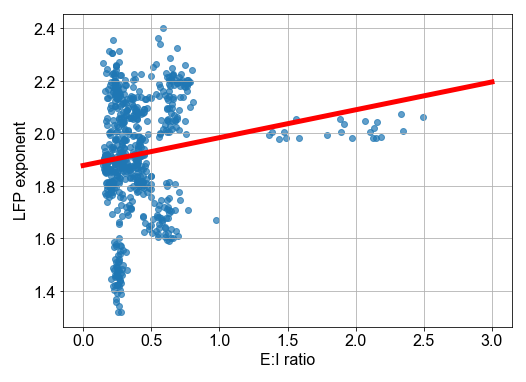

LinregressResult(slope=0.10592141361696639, intercept=1.8775445007553628, rvalue=0.16134962531068972, pvalue=4.233726724738756e-05, stderr=0.02568971071968843, intercept_stderr=0.013837011096684134)


In [175]:
# for spontaneous data

fig = plt.figure(figsize=(7,5))

behavior_df_EI.dropna(subset=['EI_balance', 'exponent'],inplace=True)

x = behavior_df_EI['EI_balance']
y = behavior_df_EI['exponent']

plt.scatter(x, y, alpha=0.7)

results = linregress(x, y)
t_lin = np.linspace(0, 3, 100)
lin = results.slope * t_lin + results.intercept

plt.plot(t_lin, lin, linewidth=5, color='red')

plt.xlabel('E:I ratio')
plt.ylabel('LFP exponent')
plt.grid(True)
plt.show()

print(results)


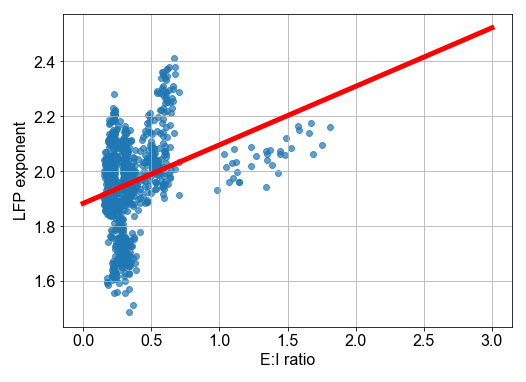

LinregressResult(slope=0.2132370965388321, intercept=1.8814652179765632, rvalue=0.310336206710938, pvalue=1.3772648136976526e-19, stderr=0.022950803130866827, intercept_stderr=0.01021739296522281)


In [176]:
# for movie/shuffled data

fig = plt.figure(figsize=(7,5))

presentation_df_EI.dropna(subset=['EI_balance', 'exponent'],inplace=True)

x = presentation_df_EI['EI_balance']
y = presentation_df_EI['exponent']

plt.scatter(x, y, alpha=0.7)

results = linregress(x, y)
t_lin = np.linspace(0, 3, 100)
lin = results.slope * t_lin + results.intercept

plt.plot(t_lin, lin, linewidth=5, color='red')

plt.xlabel('E:I ratio')
plt.ylabel('LFP exponent')
plt.grid(True)
plt.show()

print(results)


In [177]:
presentation_df_EI[presentation_df_EI['EI_balance'] > 1.0]

,session,epoch_idx,offset,knee,exponent,cf_0,pw_0,bw_0,cf_1,pw_1,...,running,region_cv,spike_distance,spike_synchrony,mean_firing_rate,mean_fano_factor,mean_cv,EI_balance,excitatory_count,inhibitory_count
718,840012044,0,-4.576764,350.880323,1.991127,28.946623,0.376220,8.418590,52.107888,0.368288,...,False,1.394998,0.163241,0.362254,8.826812,4.221105,1.7193054396888487,1.427218,29,12
719,840012044,7,-4.499764,79.880113,2.040247,24.661602,0.345287,6.426768,51.259016,0.320891,...,False,1.395359,0.158882,0.368954,7.526812,3.790529,NaN,1.346033,29,12
720,840012044,7,-4.465835,86.740687,2.061436,17.539033,0.343623,7.296647,53.975016,0.268760,...,False,1.630185,0.173933,0.343332,7.949275,1.600779,1.1501313799689272,1.346033,29,12
721,840012044,8,-4.687673,55.533231,1.940814,18.037141,0.394750,8.424108,36.689041,0.336732,...,False,1.552183,0.166274,0.360833,7.418841,NaN,[nan nan],1.338089,29,12
722,840012044,8,-4.478767,35.416891,2.072627,21.793544,0.391737,7.244097,66.326456,0.320585,...,False,1.799340,0.168784,0.342172,7.588406,1.620001,1.1833669990937552,1.338089,29,12
723,840012044,9,-4.471710,65.842933,2.059661,13.904514,0.427699,6.713958,65.168864,0.281289,...,False,1.847006,0.156548,0.357928,7.334783,NaN,[nan nan],1.443897,29,12
724,840012044,9,-4.482122,30.425123,2.070947,23.016527,0.381737,7.142937,39.707613,0.293727,...,False,1.826067,0.167302,0.338408,7.344928,NaN,[nan nan],1.443897,29,12
725,840012044,11,-4.386894,1287.002476,2.077710,10.377099,0.526102,5.891702,47.831580,0.342880,...,False,1.475782,0.166552,0.360819,8.325362,4.362046,1.651838436638192,1.371725,29,12
726,840012044,13,-4.338579,742.704009,2.118397,4.137082,0.551300,3.625191,30.371867,0.355510,...,False,1.297814,0.162226,0.367649,7.823913,NaN,[nan nan],1.485647,29,12
727,840012044,14,-4.516859,54.474174,2.059641,18.870085,0.358145,9.210441,40.080880,0.311167,...,False,1.765572,0.161017,0.359817,6.900000,3.424290,1.57082068053494,1.683846,29,12


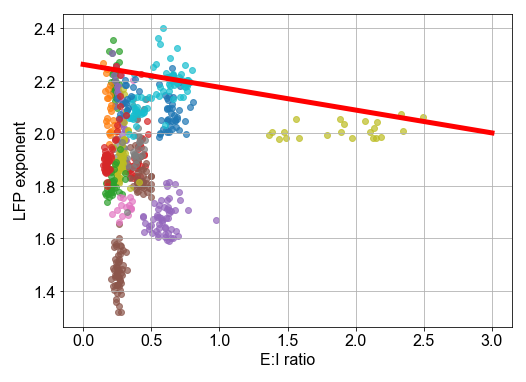

LinregressResult(slope=-0.08683901332830748, intercept=2.2620225373633804, rvalue=-0.125991117256082, pvalue=0.4510125245754981, stderr=0.11395912559476387, intercept_stderr=0.07906556577988844)


In [151]:
# spontaneous: color by subject

fig = plt.figure(figsize=(7,5))

behavior_df_EI.dropna(subset=['EI_balance', 'exponent'],inplace=True)


for subject in behavior_df_EI['session'].unique():
    
    ses_df = behavior_df_EI[behavior_df_EI['session'] == subject]
    
    x = ses_df['EI_balance']
    y = ses_df['exponent']

    plt.scatter(x, y, alpha=0.7)

results = linregress(x, y)
t_lin = np.linspace(0, 3, 100)
lin = results.slope * t_lin + results.intercept

plt.plot(t_lin, lin, linewidth=5, color='red')

plt.xlabel('E:I ratio')
plt.ylabel('LFP exponent')
plt.grid(True)
plt.show()

print(results)


In [152]:
# investigate outlier

behavior_df_EI[behavior_df_EI['EI_balance'] > 1.0]

,session,epoch_idx,offset,knee,exponent,cf_0,pw_0,bw_0,cf_1,pw_1,...,running,region_cv,spike_distance,spike_synchrony,mean_firing_rate,mean_fano_factor,mean_cv,EI_balance,excitatory_count,inhibitory_count
597,840012044,0,-4.567328,424.863217,1.994757,18.296371,0.406787,10.021811,51.277670,0.493894,...,False,1.211564,0.162568,0.369327,6.337681,2.823323,1.3374107971182665,1.361271,29,12
598,840012044,1,-4.518248,69.523975,2.047782,48.873764,0.306808,7.414663,65.908821,0.415205,...,False,1.348362,0.152292,0.362473,5.373188,2.518645,1.2603296320374309,2.068623,29,12
599,840012044,2,-4.482550,131.194634,2.072344,18.947154,0.457914,4.686864,53.289042,0.342916,...,False,1.391046,0.156958,0.362610,5.443478,1.945268,NaN,2.330328,29,12
600,840012044,3,-4.566071,443.928090,1.983501,16.849105,0.605605,6.481941,51.131657,0.401076,...,False,1.232559,0.169242,0.358834,6.652174,3.331562,1.4811469568309992,1.584198,29,12
601,840012044,4,-4.590703,117.228001,2.005363,24.664387,0.325065,9.176147,43.802717,0.521943,...,False,1.461267,0.156211,0.361663,5.847826,2.501212,1.2861245618589483,2.108435,29,12
602,840012044,5,-4.489775,31.189051,2.062932,48.687968,0.336953,9.679409,63.006223,0.380934,...,False,1.535410,0.149742,0.355220,5.501449,2.313321,1.3002609345394587,2.493710,29,12
603,840012044,6,-4.619213,83.128104,2.008412,19.447670,0.439344,5.679886,53.291063,0.444175,...,False,1.419326,0.153266,0.363690,5.571014,2.256769,NaN,2.345070,29,12
604,840012044,7,-4.535519,541.875483,2.004240,14.104609,0.552354,5.901630,49.223089,0.382750,...,False,1.171297,0.162965,0.365467,6.144203,3.112277,NaN,1.382849,29,12
605,840012044,8,-4.620223,45.543144,2.005546,35.863521,0.365158,8.978061,53.536030,0.389655,...,False,1.385602,0.149878,0.362320,5.187681,NaN,[nan nan],1.892374,29,12
606,840012044,9,-4.664101,33.036001,1.987357,21.303345,0.295919,8.244721,47.516495,0.352399,...,False,1.582203,0.154719,0.358048,5.371739,2.033049,1.3073011402459713,2.183115,29,12


In [157]:
# mean unit counts
behavior_df_EI.groupby('session').mean()

,epoch_idx,offset,knee,exponent,cf_0,pw_0,bw_0,cf_1,pw_1,bw_1,...,r_squared,running,region_cv,spike_distance,spike_synchrony,mean_firing_rate,mean_fano_factor,EI_balance,excitatory_count,inhibitory_count
session,,,,,,,,,,,,,,,,,,,,,
766640955,21.500000,-4.524636,1257.607818,2.083156,16.706542,0.487510,5.907979,52.306913,0.461150,8.738929,...,0.977607,0.0,1.159467,0.162744,0.364134,5.723114,2.607422,0.652895,35.0,10.0
767871931,5.000000,-4.556528,2234.531553,2.020519,13.648136,0.434287,5.187273,43.656208,0.280974,11.749925,...,0.980926,0.0,1.578531,0.136697,0.365663,5.445305,NaN,0.235909,70.0,18.0
768515987,16.000000,-4.072870,10711.366101,2.194962,10.397541,0.442632,4.988412,44.141714,0.307337,10.427620,...,0.983126,0.0,1.251254,0.141637,0.369265,5.865895,3.132597,0.233670,47.0,19.0
771160300,20.000000,-4.751086,18870.171111,1.918614,25.604235,0.437401,8.253806,52.388439,0.382633,9.550181,...,0.965383,0.0,1.665326,0.144874,0.355892,4.776069,2.844919,0.397412,64.0,12.0
771990200,13.888889,-4.252223,27649.657432,2.111877,20.149893,0.417072,6.928382,50.552331,0.363002,10.219748,...,0.974636,0.0,1.296282,0.162283,0.381228,6.803635,2.450004,0.269988,42.0,10.0
774875821,19.000000,-5.276564,219.204114,1.828175,20.656003,0.447799,6.348607,58.180875,0.403752,9.095031,...,0.972935,0.0,1.499437,0.160332,0.366300,4.633519,2.462659,0.428448,50.0,11.0
778240327,0.000000,-4.301647,40282.553614,2.200899,13.305932,0.582722,5.016386,68.755449,0.361729,11.076520,...,0.966725,0.0,1.099674,0.142709,0.364903,4.794118,3.048063,0.362112,66.0,12.0
778998620,18.000000,-5.022075,1848.888557,1.959493,33.550924,0.391972,9.033699,69.915732,0.374737,9.941625,...,0.973553,0.0,1.680567,0.130536,0.351081,4.123291,2.662312,0.354581,56.0,11.0
779839471,24.500000,-4.982185,4972.728384,1.909812,26.930113,0.383145,8.178695,58.005809,0.344535,9.823415,...,0.968914,0.0,1.970451,0.133439,0.352624,4.263063,3.047064,0.277103,99.0,17.0


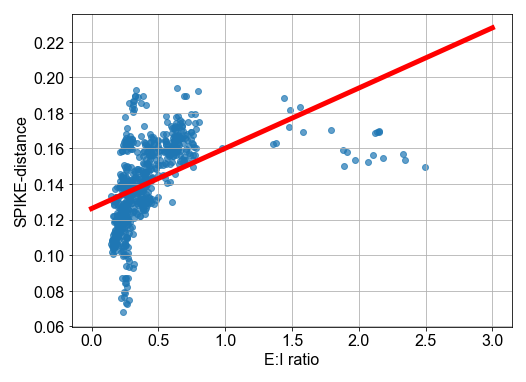

LinregressResult(slope=0.03387799440904414, intercept=0.12620573438725188, rvalue=0.47809962334870665, pvalue=9.481854319676556e-38, stderr=0.002467836543516579, intercept_stderr=0.001329227954726291)


In [125]:
fig = plt.figure(figsize=(7,5))

behavior_df_EI.dropna(subset=['EI_balance', 'spike_distance'],inplace=True)

x = behavior_df_EI['EI_balance']
y = behavior_df_EI['spike_distance']

plt.scatter(x, y, alpha=0.7)

results = linregress(x, y)
t_lin = np.linspace(0, 3, 100)
lin = results.slope * t_lin + results.intercept

plt.plot(t_lin, lin, linewidth=5, color='red')

plt.xlabel('E:I ratio')
plt.ylabel('SPIKE-distance')
plt.grid(True)
plt.show()

print(results)


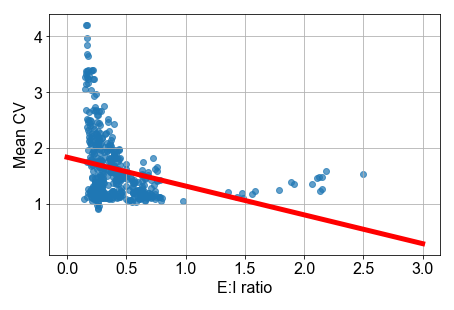

LinregressResult(slope=-0.5146541346341402, intercept=1.8297450664988442, rvalue=-0.28821596489701234, pvalue=1.1805033067624995e-10, stderr=0.07812645809084022, intercept_stderr=0.041964009182058025)


In [134]:

fig = plt.figure()

behavior_df_EI.dropna(subset=['EI_balance', 'region_cv'],inplace=True)

x = behavior_df_EI['EI_balance']
y = behavior_df_EI['region_cv']

plt.scatter(x, y, alpha=0.7)

results = linregress(x, y)
t_lin = np.linspace(0, 3, 100)
lin = results.slope * t_lin + results.intercept

plt.plot(t_lin, lin, linewidth=5, color='red')

plt.xlabel('E:I ratio')
plt.ylabel('Mean CV')
plt.grid(True)
plt.show()

print(results)


## Mixed LM

In [126]:
behavior_df.columns

Index(['session', 'epoch_idx', 'offset', 'knee', 'exponent', 'cf_0', 'pw_0',
       'bw_0', 'cf_1', 'pw_1', 'bw_1', 'cf_2', 'pw_2', 'bw_2', 'cf_3', 'pw_3',
       'bw_3', 'error', 'r_squared', 'behavior', 'brain_structure',
       'epoch_times', 'running', 'region_cv', 'spike_distance',
       'spike_synchrony', 'mean_firing_rate', 'mean_fano_factor', 'mean_cv'],
      dtype='object')

In [158]:
from allen_vc.stats import mixedLM

covariates = ['mean_firing_rate', 'EI_balance', 'spike_distance']
mixedLM(behavior_df_EI, 'offset', covariates, 'session')
results = mixedLM(behavior_df_EI, 'exponent', covariates, 'session')

          Mixed Linear Model Regression Results
Model:              MixedLM  Dependent Variable:  offset  
No. Observations:   638      Method:              REML    
No. Groups:         20       Scale:               0.0211  
Min. group size:    1        Log-Likelihood:      217.4110
Max. group size:    57       Converged:           Yes     
Mean group size:    31.9                                  
----------------------------------------------------------
                 Coef.  Std.Err.   z   P>|z| [0.025 0.975]
----------------------------------------------------------
mean_firing_rate  0.021    0.007 2.902 0.004  0.007  0.035
EI_balance        0.226    0.073 3.095 0.002  0.083  0.370
spike_distance    5.443    0.690 7.888 0.000  4.090  6.795
Group Var        32.614   71.839                          

          Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  exponent
No. Observations:  638      Method:              REML    
No. Groups:        2

In [159]:
dir(results)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cache',
 '_data_attr',
 '_data_in_cache',
 '_expand_re_names',
 '_get_robustcov_results',
 '_use_t',
 'aic',
 'bic',
 'bootstrap',
 'bse',
 'bse_fe',
 'bse_re',
 'bsejac',
 'bsejhj',
 'conf_int',
 'converged',
 'cov_params',
 'cov_pen',
 'cov_re',
 'cov_re_unscaled',
 'covjac',
 'covjhj',
 'df_modelwc',
 'df_resid',
 'f_test',
 'fe_params',
 'fittedvalues',
 'freepat',
 'get_nlfun',
 'hessv',
 'hist',
 'initialize',
 'k_constant',
 'k_fe',
 'k_re',
 'k_re2',
 'k_vc',
 'llf',
 'load',
 'method',
 'model',
 'nobs',
 'normalized_cov_params',
 'params',
 'params_object',
 'predict',
 'profile_re',
 'pvalues',
 'random_effec

In [165]:
behavior_df_EI['exponent'].values

array([2.01608908, 2.12705936, 2.09750831, 2.05099883, 2.24922091,
       2.04545661, 2.0952973 , 2.13791079, 2.06060239, 2.05076803,
       2.05545861, 2.05534126, 2.09313894, 2.22106163, 2.08694671,
       1.99627551, 2.01256873, 2.07823804, 2.19138765, 2.11904776,
       2.09842597, 2.01778058, 2.04536962, 2.00439588, 2.11102925,
       2.06951279, 2.04879095, 2.00122269, 2.00306904, 2.18900142,
       2.02299033, 2.04658189, 2.02782277, 2.01430658, 1.99885015,
       2.14474241, 2.14067093, 2.19834411, 2.18060032, 2.13512368,
       2.09431442, 2.19411145, 1.98590543, 2.04550616, 2.00604376,
       2.06100867, 2.00491657, 2.03250726, 2.04963502, 1.99527133,
       2.00966031, 1.95756688, 2.04343122, 2.0431017 , 2.02256841,
       2.35341862, 2.31144547, 2.19434134, 2.30391019, 2.23067472,
       2.2263714 , 2.23926674, 2.19938346, 2.17239646, 2.27286067,
       2.25796984, 2.22924901, 2.1745576 , 2.1839155 , 2.17118678,
       2.14476522, 2.3123024 , 2.19903745, 2.16453006, 2.12986

(array([ 38.,  18.,  13.,  57.,  74., 107.,  98.,  67., 110.,  56.]),
 array([1.40467335, 1.49143053, 1.57818771, 1.66494489, 1.75170207,
        1.83845925, 1.92521643, 2.01197361, 2.09873079, 2.18548797,
        2.27224515]),
 <BarContainer object of 10 artists>)

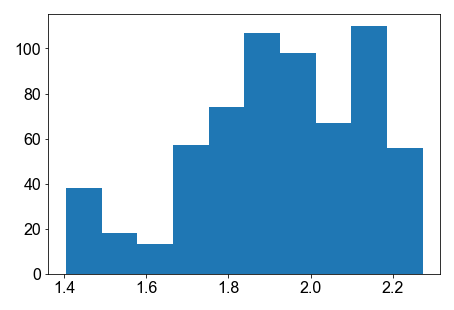

In [167]:
plt.hist(results.fittedvalues)

(array([ 14.,  30.,  31.,  45., 105., 125., 112., 108.,  59.,   9.]),
 array([1.31879125, 1.42703066, 1.53527007, 1.64350948, 1.7517489 ,
        1.85998831, 1.96822772, 2.07646713, 2.18470654, 2.29294596,
        2.40118537]),
 <BarContainer object of 10 artists>)

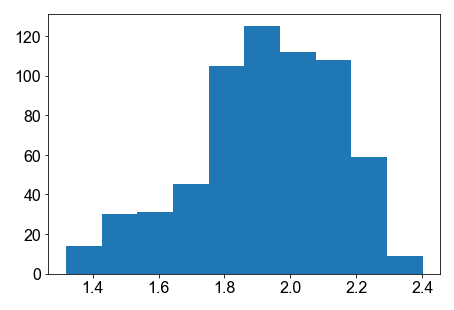

In [168]:
plt.hist(behavior_df_EI['exponent'])